In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Notes and references
**Some useful posts and notebooks**<br>
**introduction notebook**:
https://www.kaggle.com/code/tomforbes/optiver-trading-at-the-close-introduction

**post that explains the intro**: https://www.kaggle.com/competitions/optiver-trading-at-the-close/discussion/445025

**feature selection**:
https://www.kaggle.com/competitions/optiver-trading-at-the-close/discussion/453609

**xgboost model notes**
I can actually use an L1 objective function now in xgboost (i.e. mae)<br>
[https://medium.com/towards-data-science/xgboost-now-support-mae-as-objective-fdbbe18e173](http://) <br>
https://xgboost.readthedocs.io/en/stable/parameter.html#learning-task-parameters

## Import and format data

In [4]:
train = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
test = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv')
display(train.shape)
display(test.shape)

(5237980, 17)

(33000, 17)

**Will split the "explanatory features" from "target features" and split data 
into "train/validation/test" set.**<br>

Note from the code below can see the "example test set" is just the last three days of data, and without the "target" label, but instead with the label "revealed". 

```python
#can see that "imbalance size" is this same on day 478 for stock 0
(
test.query("stock_id==0")['imbalance_size'].reset_index(drop=True) 
== train.query("stock_id==0 & date_id>=478")['imbalance_size'].reset_index(drop=True)
).all()
```

**Will also drop some features like row_id, time_id that dont seem helpful for prediction**


In [5]:
features = [col for col in train.columns if col not in ['target','row_id','time_id']]
#drop the rows where target is "na" (this will be useless for training)
train.dropna(subset=['target'],inplace=True)
train.reset_index(drop=True,inplace=True)  #not sure why I do this...

#total number of days
total_days = len(train['date_id'].unique())
#do a train/valid/test split (70,15,15)
train_days = int(total_days*(0.7))
valid_days = int(total_days*(0.15))  #validation set is roughly 15%
test_days = total_days - train_days-valid_days  #remaining days for testing

_train = train.query(f"date_id<={train_days}")  #split the data according to dates
_valid = train.query(f"date_id > {train_days} & date_id<={train_days + valid_days}")
_test = train.query(f"date_id>{train_days + valid_days}")

#split of the "target" labels and the useless columns 
X_train,y_train = _train[features].copy(deep=True), _train['target'].copy(deep=True)
X_valid,y_valid = _valid[features].copy(deep=True), _valid['target'].copy(deep=True)
X_test,y_test = _test[features].copy(deep=True), _test['target'].copy(deep=True)

#"final test"
_test = train.query(f"date_id>={478}")
X_final_test, y_final_test = _test[features].copy(deep=True), _test['target'].copy(deep=True)


### Fit a "naive" model

Now I will initially fit a model to the data before diving into any serious feature exploration/engineering. For now I will try ```XGBRegressor```:<br>
[https://xgboost.readthedocs.io/en/stable/parameter.html#learning-task-parameters](http://)

At the end of the cell I then compute the MAE for train/valid/test **and** compare to the 
*benchmark prediction* which just predicts ```target=0``` in all cases. 

In [7]:
#maybe I will first just try a naive model with XGBRegressor
fit_params = {"early_stopping_rounds": 10,
              "eval_metric": "mae", #  rmse, mae, logloss, error, merror, mlogloss, auc
             "objective":"reg:absoluteerror" #reg:absoluteerror, reg:squarederror
             }

model = XGBRegressor(**fit_params)
model.fit(X_train,y_train, eval_set = [(X_valid, y_valid)])

#benchmark strategy is just set y_pred =0

#compute some predictions and compare to benchmarks
y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)
y_pred_test = model.predict(X_test)


#the benchmark errors for each set
mae_train_bench = y_train.abs().mean()
mae_valid_bench = y_valid.abs().mean()
mae_test_bench = y_test.abs().mean()

#the model errors for each set
mae_train = (y_pred_train-y_train).abs().mean()
mae_valid = (y_pred_valid-y_valid).abs().mean()
mae_test = (y_pred_test-y_test).abs().mean()

#the "improvements" for each error (in BASIS POINTS)
improve_train = mae_train_bench-mae_train
improve_valid = mae_valid_bench-mae_valid
improve_test = mae_test_bench-mae_test

print(f"TRAIN\n bench_error: {mae_train_bench:.4f}, error: {mae_train:.4f}, improvement (bps): {improve_train:.4f}")
print(f"VALIDATION\n bench_error: {mae_valid_bench:.4f}, error: {mae_valid:.4f}, improvement (bps): {improve_valid:.4f}")
print(f"TEST\n bench_error: {mae_test_bench:.4f}, error: {mae_test:.4f}, improvement (bps): {improve_test:.4f}")



[0]	validation_0-mae:6.46532
[1]	validation_0-mae:6.45352
[2]	validation_0-mae:6.44648
[3]	validation_0-mae:6.44080
[4]	validation_0-mae:6.43725
[5]	validation_0-mae:6.43462
[6]	validation_0-mae:6.43234
[7]	validation_0-mae:6.43072
[8]	validation_0-mae:6.42955
[9]	validation_0-mae:6.42638
[10]	validation_0-mae:6.42584
[11]	validation_0-mae:6.42471
[12]	validation_0-mae:6.42298
[13]	validation_0-mae:6.42164
[14]	validation_0-mae:6.42267
[15]	validation_0-mae:6.42106
[16]	validation_0-mae:6.42095
[17]	validation_0-mae:6.41983
[18]	validation_0-mae:6.41871
[19]	validation_0-mae:6.42208
[20]	validation_0-mae:6.42155
[21]	validation_0-mae:6.42072
[22]	validation_0-mae:6.42061
[23]	validation_0-mae:6.41990
[24]	validation_0-mae:6.41950
[25]	validation_0-mae:6.41931
[26]	validation_0-mae:6.41933
[27]	validation_0-mae:6.41942
TRAIN
 bench_error: 6.5096, error: 6.3910, improvement (bps): 0.1186
VALIDATION
 bench_error: 6.4905, error: 6.4187, improvement (bps): 0.0718
TEST
 bench_error: 5.8554, 

#### Some outputs for certain parameters:

**using squared error objective**<br>
*params*
```python
fit_params = {"early_stopping_rounds": 100,
              "eval_metric": "mae", #  rmse, mae, logloss, error, merror, mlogloss, auc
             "objective":"reg:squarederror" #reg:absoluteerror, reg:squarederror
             }
```
*output*
```
TRAIN
 bench_error: 6.5096, error: 6.4049, improvement (bps): 0.1046
VALIDATION
 bench_error: 6.4905, error: 6.4293, improvement (bps): 0.0611
TEST
 bench_error: 5.8554, error: 5.8095, improvement (bps): 0.0459
 ```

**Using absolute error objective**<br>

*params*
```python
fit_params = {"early_stopping_rounds": 10,
              "eval_metric": "mae", #  rmse, mae, logloss, error, merror, mlogloss, auc
             "objective":"reg:absoluteerror" #reg:absoluteerror, reg:squarederror
             }
```

*output*
```
TRAIN
 bench_error: 6.5096, error: 6.3910, improvement (bps): 0.1186
VALIDATION
 bench_error: 6.4905, error: 6.4187, improvement (bps): 0.0718
TEST
 bench_error: 5.8554, error: 5.8007, improvement (bps): 0.0547
 ```


*params*
```python
fit_params = {"early_stopping_rounds": 100,
              "eval_metric": "mae", #  rmse, mae, logloss, error, merror, mlogloss, auc
             "objective":"reg:absoluteerror" #reg:absoluteerror, reg:squarederror
             }
```
*output*
```
TRAIN
 bench_error: 6.5096, error: 6.3411, improvement (bps): 0.1685
VALIDATION
 bench_error: 6.4905, error: 6.4154, improvement (bps): 0.0750
TEST
 bench_error: 5.8554, error: 5.8103, improvement (bps): 0.0451
 ```


### How to "generate" submission.csv

Some variant of the code below will generate the submission file. I need to use and API provided with the ```optiver2023``` library.

```python
counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
    
    # preprocess
    X_test = test[features].copy(deep=True)
    X_test = feature_engineering(X_test)
    #X_test['stock_id'] = X_test['stock_id'].astype(str)
    #X_test = X_test[summary['selected_features_names']]
    X_test = X_test.astype(np.float32)
    
    # predict
    sample_prediction['target'] = final_model.predict(X_test)
    env.predict(sample_prediction)
    counter += 1
```

In [8]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

counter = 0
for (test, revealed_targets,sample_prediction) in iter_test:
    #preprocess
    X_final = test[features].copy(deep=True)  #just choose the "useful" features
    
    #predict
    sample_prediction['target'] = model.predict(X_final)
    env.predict(sample_prediction)
    counter+=1
print(f"total iterations: {counter}")

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
total iterations: 165


## Data/Feature exploration

Now I will start to seriously explore the data and features, and I will try to better understand the problem. 

In [15]:
def plot_data(df,stock_id,date_id):
    """
    plots the bid/wap/ask prices of stock in the closing minutes, and the far price, reference price, near price
    df (dataframe): dataframe of stock prices
    stock_id (int): denotes the id of target stock
    date_id (int): denotes id of the desired day
    """
    fig, ax = plt.subplots(nrows=3,figsize=(10,15))
    df_plot_spread=df.query(f'stock_id == {stock_id} & date_id=={date_id}')[['seconds_in_bucket','bid_price','wap','ask_price','reference_price']]
    df_plot_spread.set_index('seconds_in_bucket',inplace=True)
    df_plot_spread.plot(ax=ax[0],xlabel='')
    ax[0].set_title(f'order book data for stock {stock_id} on day {date_id}')
    df_plot_auction=df.query(f'stock_id == {stock_id} & date_id=={date_id}')[['seconds_in_bucket','near_price','far_price','reference_price']]
    df_plot_auction.set_index('seconds_in_bucket',inplace=True)
    df_plot_auction.plot(ax=ax[1])
    ax[1].set_title(f'auction book data for stock {stock_id} on day {date_id}')
    df_plot_imb=df.query(f'stock_id == {stock_id} & date_id=={date_id}')[['seconds_in_bucket','imbalance_size','matched_size']]
    df_plot_imb.set_index('seconds_in_bucket',inplace=True)
    df_plot_imb.plot(ax=ax[2])
    ax[1].set_title(f'imbalance data for stock {stock_id} on day {date_id}')
    
    return fig, ax

In [88]:
#isolate the "price features"
price_cols = ['reference_price', 'far_price','near_price', 'bid_price', 'ask_price', 'wap']
#isolate the "size features"
size_cols = ['imbalance_size', 'matched_size', 'bid_size','ask_size']
#categorical features
cat_cols = ['imbalance_buy_sell_flag']

### Reference price
Probably the most "ambiguous" feature that is introduced in this problem is the **reference price**. I think I now understand it and I might know how to use this knowledge to improve my forecasting and engineer new features. I will first do a quick overview of the definition. 

refs: 
1. [https://www.kaggle.com/competitions/optiver-trading-at-the-close/discussion/445025](http://)
2. https://www.kaggle.com/code/tomforbes/optiver-trading-at-the-close-introduction

Some definitions:
1. the **far price** only depends on the auction book and is the price that will result in the biggest number of *matched* buy/sell it orders, i.e. it is the *uncross price*. 
2. the **near price** is the similar to the *far price* except that it involves the book that will result from merging the *auction book* with the *order book*.

There are three possible cases for the *near price*:
1. near price <= best_bid
2. best_bid < near price < best_ask
3. near price >= best_ask

The **reference price** (at time $t$) can now be defined as the price "$\text{ref}$" which satisfies:
$$
 \text{best bid} <= \text{ref} <= \text{best ask}
$$
and is *as close to the near price as possible*. Equivalently, 
1. ``reference price = best_bid    IF  near price <= best_bid``
2. ``reference price = near price  IF  best_bid < near price < best_ask``
3. ``reference price = best_ask    IF  near price >= best_ask``

#### Errors in reference price data
In our dataset, we can see that **reference price** is avaiable for all times, but **near price** and **far price** are only available when ``seconds_in_the_bucket >=300`` (e.g. after 3:55 EST).

So the reference price should NEVER be outside the bid/ask spread region, AND, should 
precisely equal the ``bid_price`` whenever ``near_price <= bid_price``, and similar for the
``ask_price``. However, in some of the examples below, I will show that in the data this doesnt always precisely hold for certain stocks, but still "approximately" holds. 

In the cell below, we compute the total number/percent of errors for a stock in ``X_train``.
To look for errors, I just look for all the examples when ``reference price`` IS NOT inbetween
``bid_price`` and ``ask_price``. 
1. for ``stock 0``, there are ``1151 errors``, which accounts for ``6.210%`` of the training data. 
2. for ``stock 1``, there are only ``314 errors``, which accounts for ``1.694%`` of the training data. 

**Theory**: In really active markets the bid/ask prices can change within *nanoseconds*, and since the *reference price* is computed from the *bid/ask* prices, then there might be a slight lag caused by its computation.

#### Some ideas and potential fixes
Since the reference price is derived from the *near price* and the *bid/ask* prices, I can just compute it myself as soon as the *near price* data becomes available. Perhaps I can call this the ``true_reference_price``.

The *reference price error* might be a useful indicator in its own right. As it might give some information about how "active" a particular stock is at a given time (e.g. high frequency volatility). One potential formula is: <br>
``reference_price_error = abs(true_reference_price-reference_price)``<br>
it will be defined when ``seconds_in_bucket >=300``. 

I can introduce a categorical feature ``near_price_position`` which takes on three values
depending whether its ``<= best_ask``, between the bid/ask, and ``>=best_ask``. 

In [31]:
#erros for pairs (stock,date)
#the pair (0,99) has only one error
#the pair (7,99) has 5 errors
stock = 0
date = 0
ref_test = X_train.query(f'stock_id=={stock} & date_id>={date}')[['seconds_in_bucket',
                                                        'bid_price',
                                                        'ask_price',
                                                        'reference_price','near_price']]
ref_test = ref_test.set_index('seconds_in_bucket')
#ref_test.loc[ref_test.index>=300].plot()
#ref_test.plot(title='stock {stock} on day {date}')

#locate all of the times when the reference price was given in error
ref_error = ref_test.query('reference_price>ask_price | reference_price<bid_price')
print(f"total errors: {len(ref_error)}, percent of total: {len(ref_error)/len(ref_test):.3%}")
display(ref_test.query('reference_price>ask_price | reference_price<bid_price'))


total errors: 1151, percent of total: 6.210%


,bid_price,ask_price,reference_price,near_price
seconds_in_bucket,,,,
120,0.999812,1.000026,1.000133,NaN
280,0.999705,1.000026,0.999383,NaN
290,1.000241,1.000776,0.999919,NaN
340,0.999169,0.999383,0.999491,0.999491
180,0.998741,0.998849,0.998634,NaN
...,...,...,...,...
230,0.999676,0.999773,0.999580,NaN
250,0.999869,0.999965,0.999580,NaN
300,0.999003,0.999195,0.999484,0.976493


<Axes: >

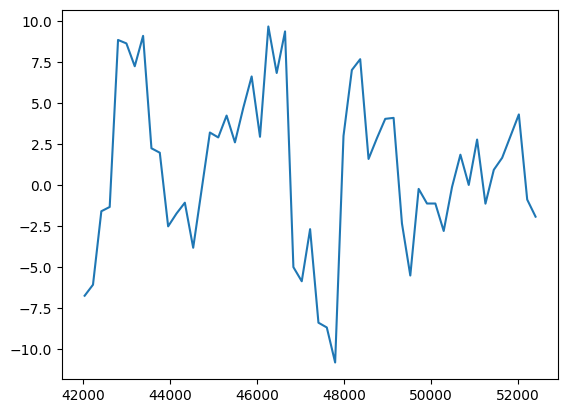

In [85]:
indx=X_train.query('date_id== 4 & stock_id==10').index
y_train[indx].plot()

In [27]:
ref_test.query('reference_price>ask_price | reference_price<bid_price')

,bid_price,ask_price,reference_price
seconds_in_bucket,,,
50,1.000004,1.000389,1.000466
80,0.999573,0.999804,0.999850
100,1.000035,1.000220,1.000020
250,1.000389,1.000528,1.000620
290,1.000974,1.001421,1.001513


In [108]:
(
    df_train.
    query("stock_id == 7 & date_id==15")[['seconds_in_bucket','far_price', 'near_price', 'reference_price']].
    query("far_price == near_price")
    
)

,seconds_in_bucket,far_price,near_price,reference_price
164523,330,1.000189,1.000189,1.000001
164715,340,1.000189,1.000189,0.999984
164907,350,1.000189,1.000189,0.999932
165099,360,1.000189,1.000189,0.999573
165291,370,1.000189,1.000189,0.999471
167211,470,1.000189,1.000189,0.999488
167403,480,0.999967,0.999967,0.999967
167595,490,1.000018,1.000018,1.000018
167787,500,1.000018,1.000018,1.000018
167979,510,1.000018,1.000018,1.000018


In [174]:
grouped_dict.keys()

dict_keys([-1, 0, 1])

In [169]:
grouped = df_train.groupby(by='imbalance_buy_sell_flag')
grouped_dict = {key:group for key, group in grouped}

<Axes: xlabel='seconds_in_bucket'>

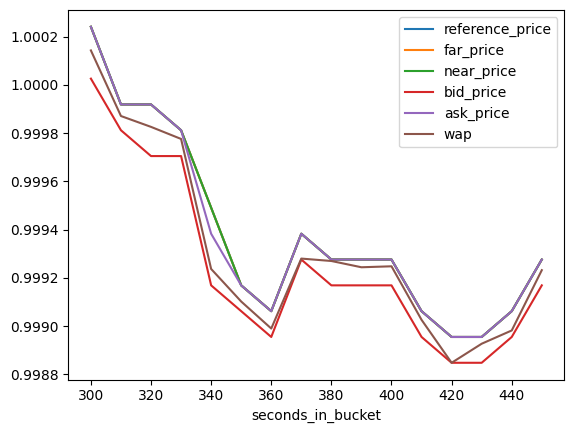

In [166]:
df_play = df_train.query('stock_id == 0 & date_id==0').set_index('seconds_in_bucket')

#essentially a dictionary of dataframes, where keys=(values of'imbalance_buy_sell_flag')
grouped = df_play[['imbalance_buy_sell_flag']+price_cols].groupby(by='imbalance_buy_sell_flag')
grouped_dict = {key:group[price_cols] for key, group in grouped}
grouped_dict[0].plot()

In [217]:
from scipy.stats import shapiro, skew,kurtosis
shapiro(df_train.query('stock_id==0 & date_id<=300')['target'])

ShapiroResult(statistic=0.9554351568222046, pvalue=0.0)

In [219]:
print(kurtosis(df_train.query('stock_id==0 & date_id<=300')['target']))
print(skew(df_train.query('stock_id==0 & date_id<=100')['target']))

5.177789329312429
-0.6557950277461849


In [279]:
fair_std = np.sqrt(len(target_play)*.25)/len(target_play)
null_hyp = [(len(target_play)/2 - 2*np.sqrt(len(target_play)*.25))/len(target_play),
            (len(target_play)/2 + 2*np.sqrt(len(target_play)*.25))/len(target_play)]
print(f"fair_std: {fair_std:.3%}")
print(f"interval {null_hyp[0]:.3%} < x < {null_hyp[1]:.3%}")

fair_std: 0.389%
interval 49.223% < x < 50.777%


In [297]:
target_play = df_train.query('stock_id==28 & date_id<=300')['target']
wins = (target_play > 0).sum()/len(target_play)
print(f"postive return {wins:.3%}")

postive return 47.998%


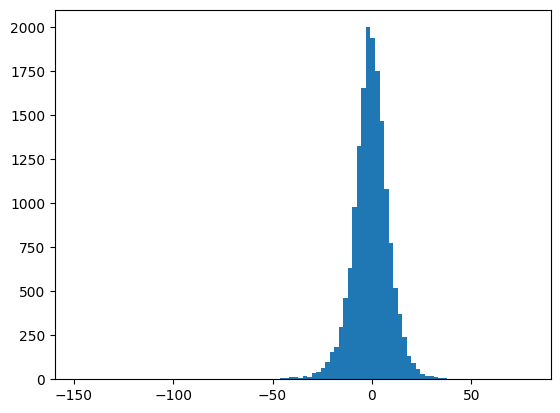

In [298]:
counts, bins, patches = plt.hist(x=target_play,bins=100)

In [36]:
df_train = pd.concat([X_train,y_train],axis=1)

<Axes: >

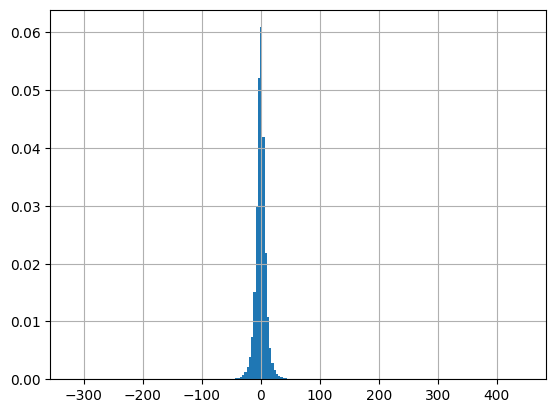

In [46]:
#indx = X_train.query('stock_id==0 & date_id<=100').index
indx = X_train.index
#df_train.query('stock_id==0 & date_id<=100')['target'].hist(bins=100,density=True)
#y_train[indx].hist(bins=200,density=True)
(y_train-y_pred_train)[indx].hist(bins=200,density=True)

In [49]:
y_train.describe()
(y_train-y_pred_train).describe()

count    3.653948e+06
mean    -1.505311e-05
std      9.397156e+00
min     -3.183290e+02
25%     -4.514167e+00
50%     -4.691006e-03
75%      4.471564e+00
max      4.462019e+02
Name: target, dtype: float64

percent within 3 std 98.494%


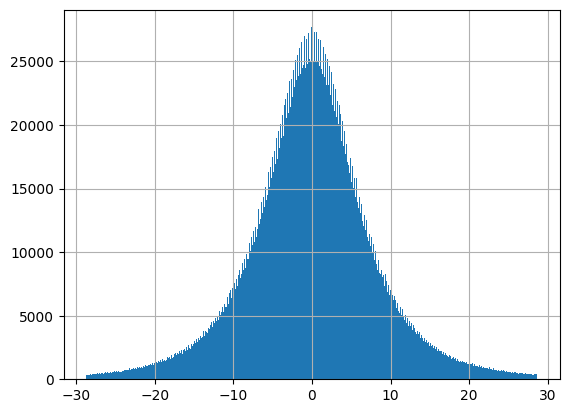

In [83]:
#error can be set to the type of error we want to look at
#error = y_train-y_pred_train  #e.g. training error
error = y_train  #e.g. benchmark error
n_std = 3  #number of standard deviations

error_interval = (
(error.mean() - n_std*error.std() < error) & 
    (error< error.mean() + n_std*error.std())
)



#replace the false values with np.nan
error_mask = (error_interval == False)
error_interval.loc[error_mask] = np.nan

#now multiply and plot
(error*error_interval).hist(bins=500)

print(f"percent within {n_std} std {error_interval.sum()/len(error_interval):.3%}")

<Axes: >

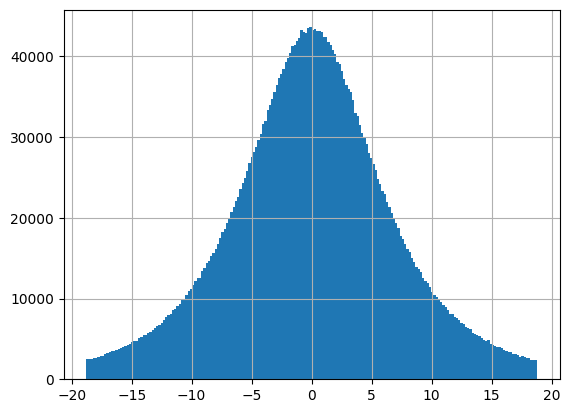

```python
for key, group in grouped:
    print(f"key: {key}")
    print(f"group: {group}")
    display(group[price_cols])
    print("\n\n")
```

In [150]:
grouped.groups
group_dict = {key: df for key, df in grouped}